In [387]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import random
warnings.filterwarnings('ignore')

In [388]:
# Loading the trained model and the scaler used to train the model
model=tf.keras.models.load_model('model_e100_filtered_1.h5')
scl=joblib.load('scaler_e100_filtered_1.joblib')

In [389]:
# Read the csv
df=pd.read_csv('Test_Dataset\high_LTV_new.csv')
df.drop(['PREPAYMENT_AMT','Time to Die'], axis = 1, inplace = True)
# df.drop(['PREPAYMENT_AMT'], axis = 1, inplace = True)
df.head()

,Loan Identifier,Monthly Reporting Period,Channel,Original Interest Rate,Current Interest Rate,Original UPB,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,...,Property Valuation Method,High Balance Loan Indicator,Unemployment_rate,Divorce_rate,Inflation_rate,EMI,UPB_diff,Interest_Component,Previous_UPB,Remaining MFM
0,97473139,12020,0,3.75,3.75,117000.0,113808.24,360,72019,92019,...,0,0,8.1,2.3,2.5,541.845242,642.34,365.625,114450.58,354
1,97473139,22020,0,3.75,3.75,117000.0,113163.89,360,72019,92019,...,0,0,8.1,2.3,2.3,541.845242,644.35,365.625,113808.24,353
2,97473139,32020,0,3.75,3.75,117000.0,112517.53,360,72019,92019,...,0,0,8.1,2.3,1.5,541.845242,646.36,365.625,113163.89,352
3,97473139,42020,0,3.75,3.75,117000.0,106869.15,360,72019,92019,...,0,0,8.1,2.3,0.3,541.845242,5648.38,365.625,112517.53,351
4,97473139,52020,0,3.75,3.75,117000.0,106203.12,360,72019,92019,...,0,0,8.1,2.3,0.1,541.845242,666.03,365.625,106869.15,350


In [390]:
ic=[]
for i in range(len(df['Loan Identifier'])):
    ic.append(df.iloc[i,4]/1200*df.iloc[i,34])   
df['Interest_Component'] = ic

In [391]:
# Define a custom function to select the top 7 entries for each loan group
def select_top_entries(group):
    return group.tail(7)
# Create a new DataFrame with the top 7 entries for each loan
top_entries = df.groupby('Loan Identifier').apply(select_top_entries)
# Reset the index of the resulting DataFrame
top_entries = top_entries.reset_index(drop=True)
df=top_entries

In [392]:
# Preprocessing df to create test pool
test_pool=df.drop_duplicates(subset='Loan Identifier', keep ='first')
emi = list(test_pool['EMI'])
test_pool.drop(['Loan Identifier','EMI','UPB_diff','Interest_Component','Remaining Months To Maturity'], axis=1, inplace = True)
test_pool['Modification Flag']=test_pool['Modification Flag'].fillna(2)
test_pool.head()

,Monthly Reporting Period,Channel,Original Interest Rate,Current Interest Rate,Original UPB,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Original Loan to Value Ratio (LTV),...,Modification Flag,Zero Balance Code,Special Eligibility Program,Property Valuation Method,High Balance Loan Indicator,Unemployment_rate,Divorce_rate,Inflation_rate,Previous_UPB,Remaining MFM
0,32020,0,3.750,3.750,117000.0,112517.53,360,72019,92019,90,...,0,0,2,0,0,8.1,2.3,1.5,113163.89,352
7,32020,2,4.250,4.250,52000.0,49884.41,360,62019,82019,97,...,0,0,0,0,0,8.1,2.3,1.5,50045.57,351
14,42020,2,4.625,4.625,240000.0,235816.94,360,62019,82019,97,...,0,0,0,0,0,8.1,2.3,0.3,236138.78,350
21,52020,2,3.750,3.750,360000.0,355982.94,360,82019,102019,90,...,0,0,0,0,0,8.1,2.3,0.1,356537.71,351
28,62020,2,3.625,3.625,139000.0,137269.60,360,92019,112019,74,...,0,0,0,3,0,8.1,2.3,0.6,137488.19,351


In [393]:
# Splitting the test pool
X_test_pool=test_pool.drop(['Current Actual UPB'],axis=1)
y_test_pool=test_pool['Current Actual UPB']

In [394]:
# Unscaled test pool with all the columns
test_pool_unscaled = df.drop('Current Actual UPB', axis = 1)
test_pool_unscaled.drop_duplicates(subset='Loan Identifier', inplace=True)

In [395]:
# Helper functions for forecasting
# Function to update Monthly Reporting Period
def update_mrp(mrp):
    if((mrp//10000)==12):
        mrp = mrp - 110000 + 1
    else:
        mrp += 10000
    return mrp

# Unemployment Rates for the following years
Unemploy={"2000":4.0,
     "2001":4.7,
     "2002":5.8,
     "2003":6.0,
     "2004":5.5,
     "2005":5.1,
     "2006":4.6,
     "2007":4.6,
     "2008":5.8,
     "2009":9.3,
     "2010":9.6,
     "2011":8.9,
     "2012":8.1,
     "2013":7.4,
     "2014":6.2,
     "2015":5.3,
     "2016":4.9,
     "2017":4.4,
     "2018":3.9,
     "2019":3.7,
     "2020":8.1,
     "2021":5.3,
     "2022":3.6,
     "2023":3.4
     }

# Divorce Rates during the following years
divorce={"2000":4.0,
     "2001":4.0,
     "2002":3.9,
     "2003":3.8,
     "2004":3.7,
     "2005":3.6,
     "2006":3.7,
     "2007":3.6,
     "2008":3.5,
     "2009":3.5,
     "2010":3.6,
     "2011":3.6,
     "2012":3.4,
     "2013":3.3,
     "2014":3.2,
     "2015":3.1,
     "2016":3.0,
     "2017":2.9,
     "2018":2.9,
     "2019":2.7,
     "2020":2.3,
     "2021":2.5,
     "2022":2.3,
     "2023":2.3
     }

# Monthly Inflation Rates
inflation_data = {
    "12022": 7.5,
    "22022": 7.9,
    "32022": 8.5,
    "42022": 8.3,
    "52022": 8.6,
    "62022": 9.1,
    "72022": 8.5,
    "82022": 8.3,
    "92022": 8.2,
    "102022": 7.7,
    "112022": 7.1,
    "122022": 6.5,
    "12021": 1.4,
    "22021": 1.7,
    "32021": 2.6,
    "42021": 4.2,
    "52021": 5.0,
    "62021": 5.4,
    "72021": 5.4,
    "82021": 5.3,
    "92021": 5.4,
    "102021": 6.2,
    "112021": 6.8,
    "122021": 7.0,
    "12020": 2.5,
    "22020": 2.3,
    "32020": 1.5,
    "42020": 0.3,
    "52020": 0.1,
    "62020": 0.6,
    "72020": 1.0,
    "82020": 1.3,
    "92020": 1.4,
    "102020": 1.2,
    "112020": 1.2,
    "122020": 1.4,
    "12019": 1.6,
    "22019": 1.5,
    "32019": 1.9,
    "42019": 2.0,
    "52019": 1.8,
    "62019": 1.6,
    "72019": 1.8,
    "82019": 1.7,
    "92019": 1.7,
    "102019": 1.8,
    "112019": 2.1,
    "122019": 2.3,
    "12018": 2.1,
    "22018": 2.2,
    "32018": 2.4,
    "42018": 2.5,
    "52018": 2.8,
    "62018": 2.9,
    "72018": 2.9,
    "82018": 2.7,
    "92018": 2.3,
    "102018": 2.5,
    "112018": 2.2,
    "122018": 1.9,
    "12017": 2.5,
    "22017": 2.7,
    "32017": 2.4,
    "42017": 2.2,
    "52017": 1.9,
    "62017": 1.6,
    "72017": 1.7,
    "82017": 1.9,
    "92017": 2.2,
    "102017": 2.0,
    "112017": 2.2,
    "122017": 2.1,
    "12016": 1.4,
    "22016": 1.0,
    "32016": 0.9,
    "42016": 1.1,
    "52016": 1.0,
    "62016": 1.0,
    "72016": 0.8,
    "82016": 1.1,
    "92016": 1.5,
    "102016": 1.6,
    "112016": 1.7,
    "122016": 2.1,
    "12015": -0.1,
    "22015": 0.0,
    "32015": -0.1,
    "42015": -0.2,
    "52015": 0.0,
    "62015": 0.1,
    "72015": 0.2,
    "82015": 0.2,
    "92015": 0.0,
    "102015": 0.2,
    "112015": 0.5,
    "122015": 0.7,
    "12014": 1.6,
    "22014": 1.1,
    "32014": 1.5,
    "42014": 2.0,
    "52014": 2.1,
    "62014": 2.1,
    "72014": 2.0,
    "82014": 1.7,
    "92014": 1.7,
    "102014": 1.7,
    "112014": 1.3,
    "122014": 0.8,
    "12013": 1.6,
    "22013": 2.0,
    "32013": 1.5,
    "42013": 1.1,
    "52013": 1.4,
    "62013": 1.8,
    "72013": 2.0,
    "82013": 1.5,
    "92013": 1.2,
    "102013": 1.0,
    "112013": 1.2,
    "122013": 1.5,
    "12012": 2.9,
    "22012": 2.9,
    "32012": 2.7,
    "42012": 2.3,
    "52012": 1.7,
    "62012": 1.7,
    "72012": 1.4,
    "82012": 1.7,
    "92012": 2.0,
    "102012": 2.2,
    "112012": 1.8,
    "122012": 1.7,
    "12011": 1.6,
    "22011": 2.1,
    "32011": 2.7,
    "42011": 3.2,
    "52011": 3.6,
    "62011": 3.6,
    "72011": 3.6,
    "82011": 3.8,
    "92011": 3.9,
    "102011": 3.5,
    "112011": 3.4,
    "122011": 3.0,
    "12010": 2.6,
    "22010": 2.1,
    "32010": 2.3,
    "42010": 2.2,
    "52010": 2.0,
    "62010": 1.1,
    "72010": 1.2,
    "82010": 1.1,
    "92010": 1.1,
    "102010": 1.2,
    "112010": 1.1,
    "122010": 1.5,
    "12009": 0.0,
    "22009": 0.2,
    "32009": -0.4,
    "42009": -0.7,
    "52009": -1.3,
    "62009": -1.4,
    "72009": -2.1,
    "82009": -1.5,
    "92009": -1.3,
    "102009": -0.2,
    "112009": 1.8,
    "122009": 2.7,
    "12008": 4.3,
    "22008": 4.0,
    "32008": 4.0,
    "42008": 3.9,
    "52008": 4.2,
    "62008": 5.0,
    "72008": 5.6,
    "82008": 5.4,
    "92008": 4.9,
    "102008": 3.7,
    "112008": 1.1,
    "122008": 0.1,
    "12007": 2.1,
    "22007": 2.4,
    "32007": 2.8,
    "42007": 2.6,
    "52007": 2.7,
    "62007": 2.7,
    "72007": 2.4,
    "82007": 2.0,
    "92007": 2.8,
    "102007": 3.5,
    "112007": 4.3,
    "122007": 4.1,
    "12006": 4.0,
    "22006": 3.6,
    "32006": 3.4,
    "42006": 3.5,
    "52006": 4.2,
    "62006": 4.3,
    "72006": 4.1,
    "82006": 3.8,
    "92006": 2.1,
    "102006": 1.3,
    "112006": 2.0,
    "122006": 2.5,
    "12005": 3.0,
    "22005": 3.0,
    "32005": 3.1,
    "42005": 3.5,
    "52005": 2.8,
    "62005": 2.5,
    "72005": 3.2,
    "82005": 3.6,
    "92005": 4.7,
    "102005": 4.3,
    "112005": 3.5,
    "122005": 3.4,
    "12004": 1.9,
    "22004": 1.7,
    "32004": 1.7,
    "42004": 2.3,
    "52004": 3.1,
    "62004": 3.3,
    "72004": 3.0,
    "82004": 2.7,
    "92004": 2.5,
    "102004": 3.2,
    "112004": 3.5,
    "122004": 3.3,
    "12003": 2.6, 
    "22003": 3.0, 
    "32003": 3.0, 
    "42003": 2.2, 
    "52003": 2.1, 
    "62003": 2.1,
    "72003": 2.1, 
    "82003": 2.2, 
    "92003": 2.3, 
    "102003": 2.0, 
    "112003": 1.8, 
    "122003": 1.9,
    "12002": 1.1, 
    "22002": 1.1, 
    "32002": 1.5, 
    "42002": 1.6, 
    "52002": 1.2, 
    "62002": 1.1,
    "72002": 1.5, 
    "82002": 1.8, 
    "92002": 1.5, 
    "102002": 2.0, 
    "112002": 2.2, 
    "122002": 2.4,
    "12001": 3.7, 
    "22001": 3.5, 
    "32001": 2.9, 
    "42001": 3.3, 
    "52001": 3.6, 
    "62001": 3.2,
    "72001": 2.7, 
    "82001": 2.7, 
    "92001": 2.6, 
    "102001": 2.1, 
    "112001": 1.9, 
    "122001": 1.6,
    "12000": 2.7, 
    "22000": 3.2, 
    "32000": 3.8, 
    "42000": 3.1, 
    "52000": 3.2, 
    "62000": 3.7,
    "72000": 3.7, 
    "82000": 3.4, 
    "92000": 3.5, 
    "102000": 3.4, 
    "112000": 3.4, 
    "122000": 3.4,
    "12023": 6.4,
    "22023": 6.0,
    "32023": 5.0,
    "42023": 4.9
}

In [396]:
# err=[70,140,220,440,550,650,800]
err=[0,0,0,0,0,0,0]
err=[0.24088276903220626,0.45296793626219944,0.8157331386935459,1.1942036000727165,1.482927489774676,1.7758254671516782,2.290290609490555]

In [397]:
act_li=[]
pred_li=[]

In [398]:
# Function to forecast subsequent monthly payments for a test pool
pred_pc , pred_cupb = np.zeros(7), np.zeros(7)
def dnn_forecast(x_test_pool): 
    for i in range(len(x_test_pool)):
        test_unscaled = x_test_pool[i:i+1] #single loan entry
        testing_x = scl.transform(test_unscaled)  #scaling the data for prediction

        #Converting 1D array to 2D array suitable for model prediction
        single_entry = np.expand_dims(testing_x[0], axis=0) 

        for j in range(1):   
            single_pred=model.predict(single_entry)     
            
            # rd=random.uniform(0,0.4)
            rd=0
            # Using the model to generate a prediction for the particular month
            pred_cupb[j] += single_pred[0][0]-((rd*single_pred[0][0])/100)
            # Updating parameters to forecast the value for the next month

            act_li.append(df.iloc[7*i+j,6])
            pred_li.append(single_pred[0][0])

            pred_pc[j] += float(df['EMI'][i*7+j])-((single_pred[0][0]-((rd*single_pred[0][0])/100))*(test_unscaled['Current Interest Rate'])/1200)

            # test_unscaled['Previous_UPB']=df.iloc[i*7+j, 6]
            test_unscaled['Previous_UPB']=single_pred[0][0]-((rd*single_pred[0][0])/100)
            test_unscaled['Monthly Reporting Period']=update_mrp(int(test_unscaled['Monthly Reporting Period']))
            k=str(int(test_unscaled['Monthly Reporting Period']))
            k=k[::-1]
            r=k[:4]
            r=r[::-1]
            test_unscaled['Unemployment_rate']=Unemploy[r]
            test_unscaled['Divorce_rate']=divorce[r]
            test_unscaled['Inflation_rate']=inflation_data[str(int(test_unscaled['Monthly Reporting Period']))]
            test_unscaled['Remaining MFM']=int(test_unscaled['Remaining MFM'])-1

            test_scaled=(scl.transform(test_unscaled))[0]
            single_entry = np.expand_dims(test_scaled, axis=0)

In [399]:
dnn_forecast(X_test_pool)

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 31ms/step


In [400]:
pred_cupb

array([1.22821093e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [401]:
act_li

[112517.53,
 49884.41,
 235816.94,
 355982.94,
 137269.6,
 135830.85,
 294966.03,
 94565.44,
 150583.01,
 676305.74,
 63429.96,
 104196.07,
 136056.93,
 126713.49,
 235622.65,
 336797.0,
 237043.04,
 218058.76,
 116940.38,
 51944.64,
 272379.91,
 273458.67,
 248196.33,
 103935.38,
 115382.4,
 164271.6,
 388139.38,
 260998.89,
 222723.91,
 193800.33,
 203658.21,
 378646.69,
 286972.69,
 339456.91,
 348404.2,
 201053.96,
 70570.6,
 206843.54,
 64006.42,
 81246.62,
 173520.8,
 93602.47,
 276318.74,
 49039.24,
 152662.36,
 242553.61,
 190280.55,
 224514.4,
 142249.48,
 351872.25,
 173274.15,
 124424.37,
 58576.11,
 119524.9,
 115101.11,
 411755.51,
 82978.15,
 173834.94,
 77093.0,
 38925.88,
 62752.07,
 107896.8,
 204958.34,
 230295.29,
 136751.66,
 73369.89,
 308352.76,
 149469.53,
 218693.23,
 103990.96,
 168148.31,
 146739.72,
 121012.77,
 144966.44,
 261727.32,
 157585.53,
 330932.24,
 313903.28,
 54125.33,
 271304.78,
 74410.4,
 175589.59,
 57661.49,
 237852.63,
 102271.38,
 272747.95

In [402]:
pred_li

[113184.49,
 49929.414,
 235833.08,
 355970.47,
 137156.14,
 135306.25,
 299673.9,
 93938.1,
 150591.9,
 676048.7,
 64501.26,
 104471.516,
 136576.52,
 127465.53,
 235719.23,
 334803.5,
 239915.1,
 218628.73,
 116266.71,
 51931.594,
 273333.9,
 272917.9,
 251358.67,
 104755.64,
 115628.73,
 164780.16,
 390128.03,
 261601.1,
 222600.45,
 194330.53,
 205096.48,
 379797.88,
 287519.56,
 341202.78,
 349427.5,
 201004.16,
 70933.76,
 207140.7,
 63827.51,
 81101.086,
 173488.48,
 93009.91,
 276688.72,
 49004.94,
 153026.28,
 247296.25,
 190368.89,
 224409.42,
 142325.66,
 351898.1,
 174760.22,
 124872.88,
 58470.63,
 119510.75,
 115226.49,
 411595.06,
 82933.6,
 173827.89,
 76749.12,
 38893.82,
 62748.668,
 108036.47,
 205109.58,
 230128.92,
 136751.66,
 73859.36,
 308590.78,
 149450.5,
 218700.77,
 104326.72,
 168141.3,
 146546.94,
 121023.97,
 144876.83,
 261686.77,
 157511.7,
 330835.78,
 313843.88,
 54123.89,
 270037.88,
 74097.7,
 175539.39,
 57701.754,
 238234.97,
 102243.336,
 272637.

In [403]:
s1=0
s2=0

for i in range(len(pred_li)):
    s1+=act_li[i]
    s2+=pred_li[i]

In [404]:
dif=(s2-s1)/s1
dif

0.0020882330496051144

In [405]:
li3=[0.24088276903220626,0.45296793626219944,0.8157331386935459,1.1942036000727165,1.482927489774676,1.7758254671516782,2.290290609490555]

In [406]:
div=[]

for i in range(7):
    div.append((li3[i]/li3[0])*dif)

div

[0.0020882330496051144,
 0.003926817259343609,
 0.00707165940810911,
 0.01035265177184938,
 0.012855623533210868,
 0.015394780812822554,
 0.019854722540568984]

In [407]:
# Function to forecast subsequent monthly payments for a test pool
pred_pc , pred_cupb = np.zeros(7), np.zeros(7)
def dnn_forecast(x_test_pool): 
    for i in range(len(x_test_pool)):
        test_unscaled = x_test_pool[i:i+1] #single loan entry
        testing_x = scl.transform(test_unscaled)  #scaling the data for prediction

        #Converting 1D array to 2D array suitable for model prediction
        single_entry = np.expand_dims(testing_x[0], axis=0) 

        for j in range(7):   
            single_pred=model.predict(single_entry)     
            
            # rd=random.uniform(0,0.4)
            rd=div[j]
            # Using the model to generate a prediction for the particular month
            pred_cupb[j] += single_pred[0][0]-((rd*single_pred[0][0]))
            # Updating parameters to forecast the value for the next month

            act_li.append(df.iloc[7*i+j,6])
            pred_li.append(single_pred[0][0])

            pred_pc[j] += float(df['EMI'][i*7+j])-((single_pred[0][0]-((rd*single_pred[0][0])))*(test_unscaled['Current Interest Rate'])/1200)

            # test_unscaled['Previous_UPB']=df.iloc[i*7+j, 6]
            test_unscaled['Previous_UPB']=single_pred[0][0]
            test_unscaled['Monthly Reporting Period']=update_mrp(int(test_unscaled['Monthly Reporting Period']))
            k=str(int(test_unscaled['Monthly Reporting Period']))
            k=k[::-1]
            r=k[:4]
            r=r[::-1]
            test_unscaled['Unemployment_rate']=Unemploy[r]
            test_unscaled['Divorce_rate']=divorce[r]
            test_unscaled['Inflation_rate']=inflation_data[str(int(test_unscaled['Monthly Reporting Period']))]
            test_unscaled['Remaining MFM']=int(test_unscaled['Remaining MFM'])-1

            test_scaled=(scl.transform(test_unscaled))[0]
            single_entry = np.expand_dims(test_scaled, axis=0)

In [408]:
dnn_forecast(X_test_pool)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 72ms/step


In [409]:
act_sum_list=[]
pred_sum_list=[]

for i in range(1):
    s1=0
    s2=0
    for j in range(len(test_pool['Borrower Credit Score at Origination'])):
        s1+=act_li[7*j+i]
        s2+=pred_li[7*j+i]

    act_sum_list.append(s1)
    pred_sum_list.append(s2)

In [410]:
act_sum_list

[120940133.7699999]

In [411]:
pred_sum_list

[121247233.43945312]

In [412]:
print(act_li)

[112517.53, 49884.41, 235816.94, 355982.94, 137269.6, 135830.85, 294966.03, 94565.44, 150583.01, 676305.74, 63429.96, 104196.07, 136056.93, 126713.49, 235622.65, 336797.0, 237043.04, 218058.76, 116940.38, 51944.64, 272379.91, 273458.67, 248196.33, 103935.38, 115382.4, 164271.6, 388139.38, 260998.89, 222723.91, 193800.33, 203658.21, 378646.69, 286972.69, 339456.91, 348404.2, 201053.96, 70570.6, 206843.54, 64006.42, 81246.62, 173520.8, 93602.47, 276318.74, 49039.24, 152662.36, 242553.61, 190280.55, 224514.4, 142249.48, 351872.25, 173274.15, 124424.37, 58576.11, 119524.9, 115101.11, 411755.51, 82978.15, 173834.94, 77093.0, 38925.88, 62752.07, 107896.8, 204958.34, 230295.29, 136751.66, 73369.89, 308352.76, 149469.53, 218693.23, 103990.96, 168148.31, 146739.72, 121012.77, 144966.44, 261727.32, 157585.53, 330932.24, 313903.28, 54125.33, 271304.78, 74410.4, 175589.59, 57661.49, 237852.63, 102271.38, 272747.95, 144358.79, 379094.16, 159734.03, 42967.62, 248615.24, 198385.97, 248076.89, 95986.5

In [413]:
print(pred_li)

[113184.49, 49929.414, 235833.08, 355970.47, 137156.14, 135306.25, 299673.9, 93938.1, 150591.9, 676048.7, 64501.26, 104471.516, 136576.52, 127465.53, 235719.23, 334803.5, 239915.1, 218628.73, 116266.71, 51931.594, 273333.9, 272917.9, 251358.67, 104755.64, 115628.73, 164780.16, 390128.03, 261601.1, 222600.45, 194330.53, 205096.48, 379797.88, 287519.56, 341202.78, 349427.5, 201004.16, 70933.76, 207140.7, 63827.51, 81101.086, 173488.48, 93009.91, 276688.72, 49004.94, 153026.28, 247296.25, 190368.89, 224409.42, 142325.66, 351898.1, 174760.22, 124872.88, 58470.63, 119510.75, 115226.49, 411595.06, 82933.6, 173827.89, 76749.12, 38893.82, 62748.668, 108036.47, 205109.58, 230128.92, 136751.66, 73859.36, 308590.78, 149450.5, 218700.77, 104326.72, 168141.3, 146546.94, 121023.97, 144876.83, 261686.77, 157511.7, 330835.78, 313843.88, 54123.89, 270037.88, 74097.7, 175539.39, 57701.754, 238234.97, 102243.336, 272637.72, 144394.86, 379256.6, 159689.36, 44721.926, 248584.97, 197975.23, 248006.56, 96914

In [414]:
for i in range(len(act_li)):
    print(act_li[i]-pred_li[i])

-666.9621875000012
-45.00406249999651
-16.13812499999767
12.471250000002328
113.45937500000582
524.6000000000058
-4707.876249999972
627.3384375000023
-8.896249999990687
257.0524999999907
-1071.3017187500009
-275.445624999993
-519.585625000007
-752.0412499999948
-96.58437500000582
1993.5
-2872.053749999992
-569.9743749999907
673.6690625000047
13.046249999999418
-953.9962500000256
540.7637499999837
-3162.341875000013
-820.2606249999953
-246.32656250000582
-508.5562499999942
-1988.6512499999953
-602.203749999986
123.45687500000349
-530.2012500000128
-1438.2743750000081
-1151.1849999999977
-546.8724999999977
-1745.8712500000256
-1023.2999999999884
49.80374999999185
-363.1578124999942
-297.16312499999185
178.90828124999825
145.53406249999534
32.31562499998836
592.5637500000012
-369.9787500000093
34.29859374999796
-363.92125000001397
-4742.640000000014
-88.34062500001164
104.97812499999418
-76.17624999998952
-25.84375
-1486.0687500000058
-448.51281250000466
105.48109375000058
14.149999999994

In [415]:
act_pc , act_cupb, act_pupb, pred_pupb =  np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7)
for i in range(len(test_pool['Current Actual UPB'])):
    for j in range(7):
        act_pc[j] += df.iloc[i*7+j, 31] - df.iloc[i*7+j, 33]
        act_cupb[j] += df.iloc[i*7+j, 6]
        act_pupb[j] += df.iloc[i*7+j, 34]

for i in range(7):
    if i==0: pred_pupb[i] = act_pupb[i]
    else: pred_pupb[i] = pred_cupb[i-1]

In [416]:
act_smm, pred_smm, act_inflow, pred_inflow, act_cpr, pred_cpr = np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7), np.zeros(7)
for i in range(7):
    act_smm[i] = (act_pupb[i]- act_cupb[i]- act_pc[i])/act_cupb[i]
    pred_smm[i] = (pred_pupb[i]- pred_cupb[i]- pred_pc[i])/pred_cupb[i]
    act_inflow[i] = act_pupb[i]- act_cupb[i]- act_pc[i]+sum(emi)
    pred_inflow[i] = pred_pupb[i]- pred_cupb[i]- pred_pc[i]+sum(emi)
    act_cpr[i]= 1-pow(1-act_smm[i],12)
    pred_cpr[i]= 1-pow(1-pred_smm[i],12)

In [417]:
print(act_cupb)

[1.22565149e+08 1.21867043e+08 1.21075286e+08 1.20124696e+08
 1.19474902e+08 1.18659470e+08 1.17580907e+08]


In [418]:
print(pred_cupb)

[1.22564614e+08 1.21906235e+08 1.21088902e+08 1.20256139e+08
 1.19519304e+08 1.18778396e+08 1.17807940e+08]


In [419]:
for i in range(len(pred_cupb)):
    print(act_cupb[i]-pred_cupb[i])

534.4719604104757
-39191.69305561483
-13616.210255905986
-131443.28333719075
-44401.58510540426
-118925.76736219227
-227032.8761601895


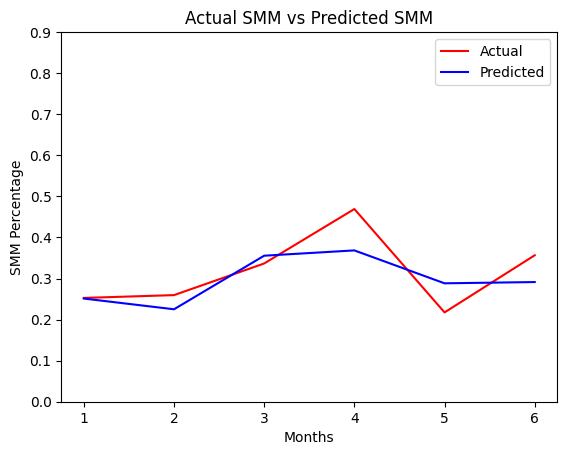

In [420]:
months = np.arange(1,7)

plt.plot(months, act_smm[:6]*100,color='red', label="Actual")
plt.plot(months, pred_smm[:6]*100,color='blue', label ="Predicted")

plt.xlabel('Months')
plt.ylabel('SMM Percentage')
plt.title('Actual SMM vs Predicted SMM')

plt.yticks(np.arange(0,1,0.1))

plt.legend()

plt.show()

In [421]:
print(act_smm)

[0.00252753 0.0025959  0.00336631 0.00469228 0.00217471 0.0035665
 0.0058129 ]


In [422]:
print(pred_smm)

[0.00251247 0.00225117 0.00355566 0.00368458 0.00288335 0.00291405
 0.00485786]


In [423]:
print(act_inflow)

[1126349.7359882  1132917.50650267 1224140.39746283 1380221.72342231
 1076386.90332029 1239761.91688547 1500049.54620258]


In [424]:
print(pred_inflow)

[1124503.13570793 1090995.02542191 1247114.49763213 1259656.07369106
 1161179.37049496 1162689.67701592 1388858.27474673]


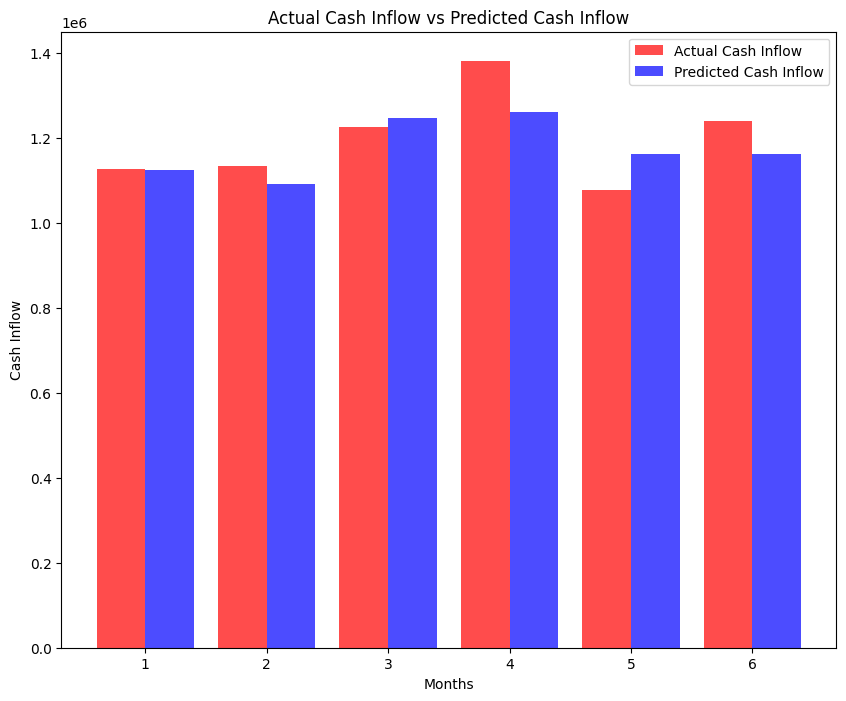

In [425]:
months = np.arange(1, 7)
bar_width = 0.4  # Width of each bar

plt.figure(figsize=(10,8))

plt.bar(months - bar_width/2, act_inflow[:6], label='Actual Cash Inflow', color='red', width=bar_width, alpha=0.7)
plt.bar(months + bar_width/2, pred_inflow[:6], label='Predicted Cash Inflow', color='blue', width=bar_width, alpha=0.7)

plt.xlabel('Months')
plt.ylabel('Cash Inflow')
plt.title('Actual Cash Inflow vs Predicted Cash Inflow')

plt.legend()
plt.show()

In [426]:
print(act_inflow)

[1126349.7359882  1132917.50650267 1224140.39746283 1380221.72342231
 1076386.90332029 1239761.91688547 1500049.54620258]


In [427]:
print(pred_inflow)

[1124503.13570793 1090995.02542191 1247114.49763213 1259656.07369106
 1161179.37049496 1162689.67701592 1388858.27474673]


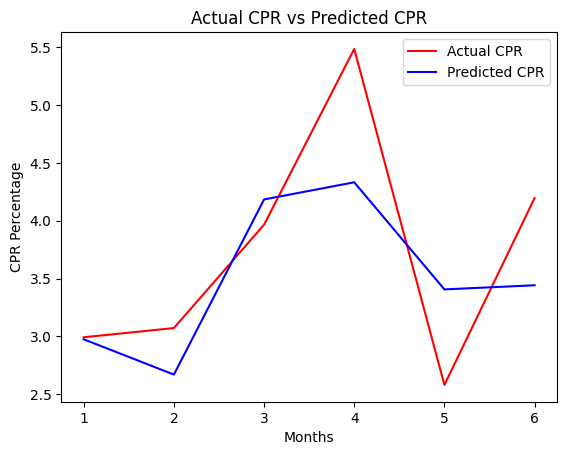

In [428]:
months = np.arange(1, 7) 

act_cpr=np.asarray(act_cpr)
pred_cpr=np.asarray(pred_cpr)

plt.plot(months, act_cpr[:6]*100, label='Actual CPR',color='red')
plt.plot(months, pred_cpr[:6]*100, label='Predicted CPR',color='blue')

plt.xlabel('Months')
plt.ylabel('CPR Percentage')
plt.title('Actual CPR vs Predicted CPR')

# plt.yticks(np.arange(0,1,1))

plt.legend()

plt.show()

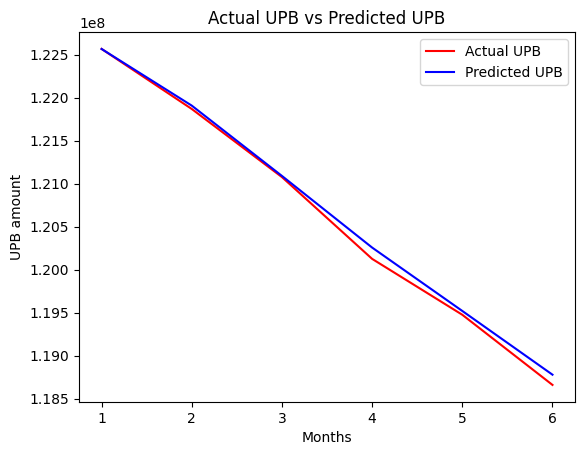

In [429]:
months = np.arange(1,7) 

plt.plot(months, act_cupb[:6], label='Actual UPB',color='red')
plt.plot(months, pred_cupb[:6], label='Predicted UPB',color='blue')

plt.xlabel('Months')
plt.ylabel('UPB amount')
plt.title('Actual UPB vs Predicted UPB')

# plt.yticks(np.arange(0, 10000000, 1000))

plt.legend()

plt.show()

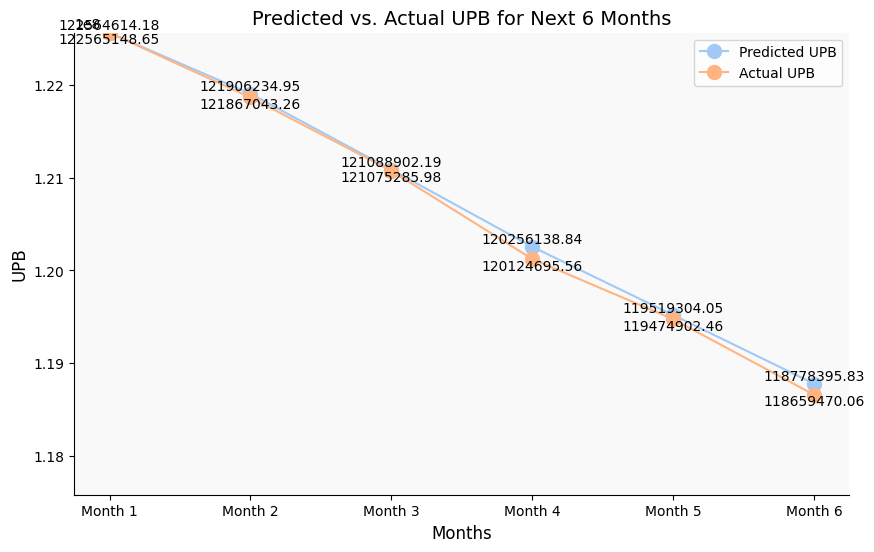

In [430]:
months = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']

# Generating colors for the plot
colors = sns.color_palette('pastel')[0:2]

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the predicted and actual UPB values
ax.plot(months, pred_cupb[:6], marker='o', markersize=10, linestyle='-', color=colors[0], label='Predicted UPB')
ax.plot(months, act_cupb[:6], marker='o', markersize=10, linestyle='-', color=colors[1], label='Actual UPB')

# Adding value annotations for predicted UPB
for i in range(len(months)):
    ax.text(i, pred_cupb[i], f'{pred_cupb[i]:.2f}', ha='center', va='bottom', fontsize=10)

# Adding value annotations for actual UPB
for i in range(len(months)):
    ax.text(i, act_cupb[i], f'{act_cupb[i]:.2f}', ha='center', va='top', fontsize=10)

# Customizing the plot aesthetics
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('UPB', fontsize=12)
ax.set_title('Predicted vs. Actual UPB for Next 6 Months', fontsize=14)
ax.legend(fontsize=10)

# Adjusting the y-axis limits
ax.set_ylim([min(np.min(pred_cupb), np.min(act_cupb)) - 100, max(np.max(pred_cupb), np.max(act_cupb)) + 100])

# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding a background color to the plot
ax.set_facecolor('#F9F9F9')

# Showing the plot
plt.show()

In [431]:
print(act_cupb)

[1.22565149e+08 1.21867043e+08 1.21075286e+08 1.20124696e+08
 1.19474902e+08 1.18659470e+08 1.17580907e+08]


In [432]:
print(pred_cupb)

[1.22564614e+08 1.21906235e+08 1.21088902e+08 1.20256139e+08
 1.19519304e+08 1.18778396e+08 1.17807940e+08]


In [433]:
diff=[]

for i in range(7):
    diff.append(pred_cupb[i]-act_cupb[i])

print(diff)

[-534.4719604104757, 39191.69305561483, 13616.210255905986, 131443.28333719075, 44401.58510540426, 118925.76736219227, 227032.8761601895]


In [434]:
error=[]

for i in range(7):
    error.append((diff[i]/act_cupb[i])*100)

print(error)

[-0.00043607172699372076, 0.0321593861697296, 0.011246069043483572, 0.10942236542155245, 0.037163943381556444, 0.10022442144909086, 0.19308651482545597]
